Demonstration of MouseGAN based Symbolic Music Generation

Inspired by: https://github.com/salu133445/musegan/tree/main

In [1]:

# importing the necessary libraries
import os
import numpy as np
import tensorflow as tf
import tarfile
import json
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Dict, Any, Tuple
from pathlib import Path
from IPython.display import display, Audio, HTML, Markdown
import warnings
warnings.filterwarnings('ignore')

# Disable TensorFlow warnings for cleaner output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set up matplotlib for better plotting in notebooks
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")


Libraries imported successfully!
TensorFlow version: 2.15.0
NumPy version: 1.26.4


In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pretty_midi
from pathlib import Path

tf.compat.v1.disable_eager_execution()
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

class MuseGANGenerator:
    def __init__(self, model_path: str, verbose=True):
        self.model_path = model_path
        self.verbose = verbose

        self.n_tracks = 5
        self.n_bars = 4
        self.n_steps_per_bar = 24
        self.n_pitches = 84
        self.lowest_pitch = 24

        self.track_names = ['Drums', 'Piano', 'Guitar', 'Bass', 'Strings']
        
        self.sess = None
        self.graph = None

        if self.verbose:
            print("✅ MuseGANGenerator initialized")

    def load_model(self) -> bool:
        ckpt_pref = None

        # find the .meta file
        for root, _, files in os.walk(self.model_path):
            for f in files:
                if f.endswith(".meta"):
                    ckpt_pref = str(Path(root) / f[:-5])
                    break
            if ckpt_pref:
                break

        if ckpt_pref is None:
            if self.verbose:
                print("⚠️ No checkpoint found; exiting.")
            return False

        try:
            self.sess = tf.compat.v1.Session()
            saver = tf.compat.v1.train.import_meta_graph(ckpt_pref + ".meta")

            saver.restore(self.sess, ckpt_pref)
            self.graph = tf.compat.v1.get_default_graph()

            print("Graph operation names:")
            for op in self.graph.get_operations():
                print(op.name)
                

            # check tensors explicitly
            self.z_shared = self.graph.get_tensor_by_name("z_shared:0")
            self.z_temporal_shared = self.graph.get_tensor_by_name("z_temporal_shared:0")
            self.music_logits = self.graph.get_tensor_by_name("bar_merged/music_logits:0")

            if self.verbose:
                print(f"✅ Loaded MuseGAN checkpoint from {ckpt_pref}")
            return True

        except Exception as e:
            if self.verbose:
                print(f"❌ Failed to load MuseGAN checkpoint: {e}")
            return False

    def generate_music(self, n_samples=4, temperature=1.0):
        if self.sess is None or self.graph is None:
            raise RuntimeError("Model is not loaded. Please call load_model first.")

        noise_shared = np.random.randn(n_samples, 128) * temperature
        noise_temp = np.random.randn(n_samples, 128) * temperature

        feed = {
            self.z_shared: noise_shared,
            self.z_temporal_shared: noise_temp
        }

        logits = self.sess.run(self.music_logits, feed_dict=feed)
        if self.verbose:
            print(f"🎵 Generated music logits: {logits.shape}")
        return logits

    def postprocess_music(self, logits, threshold=0.0):
        piano_roll = (logits > threshold).astype(np.float32)
        piano_roll[..., :self.lowest_pitch] = 0
        return piano_roll

    def plot_pianoroll(self, music, sample_idx=0, track_idx=1):
        track_roll = music[sample_idx, :, track_idx, :, :].reshape(-1, self.n_pitches)
        plt.figure(figsize=(12,4))
        plt.imshow(track_roll.T, aspect='auto', origin='lower', cmap='Blues')
        plt.title(f"{self.track_names[track_idx]} Track - Sample {sample_idx}")
        plt.xlabel('Time step')
        plt.ylabel('Pitch')
        plt.colorbar(label='Velocity')
        plt.show()

    def save_as_midi(self, music, filename="generated.mid", tempo=120):
        midi = pretty_midi.PrettyMIDI(initial_tempo=tempo)
        step_time = 60 / tempo / (self.n_steps_per_bar / 4)

        for track_idx in range(self.n_tracks):
            instr = pretty_midi.Instrument(
                program=0 if track_idx == 0 else track_idx * 8,
                is_drum=(track_idx==0),
                name=self.track_names[track_idx]
            )
            track_roll = music[0, :, track_idx, :, :].reshape(-1, self.n_pitches)
            for step, pitches in enumerate(track_roll):
                for pitch, vel in enumerate(pitches):
                    if vel > 0:
                        start = step * step_time
                        end = start + step_time
                        instr.notes.append(pretty_midi.Note(velocity=int(vel*127), pitch=pitch, start=start, end=end))
            midi.instruments.append(instr)
        midi.write(filename)
        if self.verbose:
            print(f"💾 MIDI saved: {filename}")

In [ ]:
MODEL_DIR = "pretrained_model/bass/model"  

gen = MuseGANGenerator(MODEL_DIR)
if gen.load_model():
    logits = gen.generate_music(n_samples=2, temperature=1.0)
    music = gen.postprocess_music(logits)

    gen.plot_pianoroll(music, sample_idx=0, track_idx=1) # Piano
    gen.save_as_midi(music, filename="mousegan_output.mid")
else:
    print("Model loading failed, aborting.")

# # Path to the pretrained model directory or tar file
# MODEL_PATH = "pretrained_model/default/model"  

# # Generation parameters
# N_SAMPLES = 4
# TEMPERATURE = 1.0
# THRESHOLD = 0.5
# OUTPUT_DIR = "./generated_music"

# # Create output directory
# os.makedirs(OUTPUT_DIR, exist_ok=True)

# # Initialize generator
# print("Initializing MuseGAN generator...")
# generator = MuseGANGenerator(MODEL_PATH, verbose=True)

✅ MuseGANGenerator initialized

INFO:tensorflow:Restoring parameters from pretrained_model\default\model\model.ckpt-300450
Graph operation names:
tensors/component_0
num_parallel_calls
buffer_size
seed
seed2
count
batch_size
drop_remainder
buffer_size_1
OneShotIterator
IteratorToStringHandle
IteratorGetNext
Model/global_step/Initializer/zeros
Model/global_step
Model/global_step/Assign
Model/global_step/read
Model/gen_step/Initializer/Const
Model/gen_step
Model/gen_step/Assign
Model/gen_step/read
Model_1/truncated_normal/shape
Model_1/truncated_normal/mean
Model_1/truncated_normal/stddev
Model_1/truncated_normal/TruncatedNormal
Model_1/truncated_normal/mul
Model_1/truncated_normal
Model/slope/Initializer/Const
Model/slope
Model/slope/Assign
Model/slope/read
Model_1/Generator/ExpandDims/dim
Model_1/Generator/ExpandDims
Model_1/Generator/ExpandDims_1/dim
Model_1/Generator/ExpandDims_1
Model_1/Generator/ExpandDims_2/dim
Model_1/Generator/ExpandDims_2
Model/Generator/shared/conv3d_transpose

In [4]:
# print("Loading pretrained model...")
# model_loaded = generator.load_model()

# if model_loaded:
#     print("Model loaded successfully!")
# else:
#     print("Using fallback generator (model not found or failed to load)")

In [5]:
# print(f"Generating {N_SAMPLES} music samples...")
# print(f"Parameters: Temperature={TEMPERATURE}, Threshold={THRESHOLD}")

# # Generate music
# generated_music = generator.generate_music(
#     n_samples=N_SAMPLES,
#     temperature=TEMPERATURE
# )

# # Postprocess music
# processed_music = generator.postprocess_music(generated_music, THRESHOLD)

# print("Music generation complete!")
# print(f"Generated music shape: {processed_music.shape}")

In [6]:
print("Analyzing generated music...")

# Get statistics
stats = generator.analyze_music_statistics(processed_music)

# Display statistics in a nice format
print("\n" + "="*60)
print("GENERATED MUSIC STATISTICS")
print("="*60)

for track_name, track_stats in stats.items():
    print(f"\n {track_name.upper()}:")
    print(f"   Active Notes: {track_stats['active_notes']:,}")
    print(f"   Density: {track_stats['density']:.1f}%")
    print(f"   Pitch Range: {track_stats['pitch_range'][0]} - {track_stats['pitch_range'][1]}")
    print(f"   Unique Pitches: {track_stats['unique_pitches']}")

Analyzing generated music...


NameError: name 'generator' is not defined

 Creating visualizations...

 Piano Roll Visualization (Piano Track):


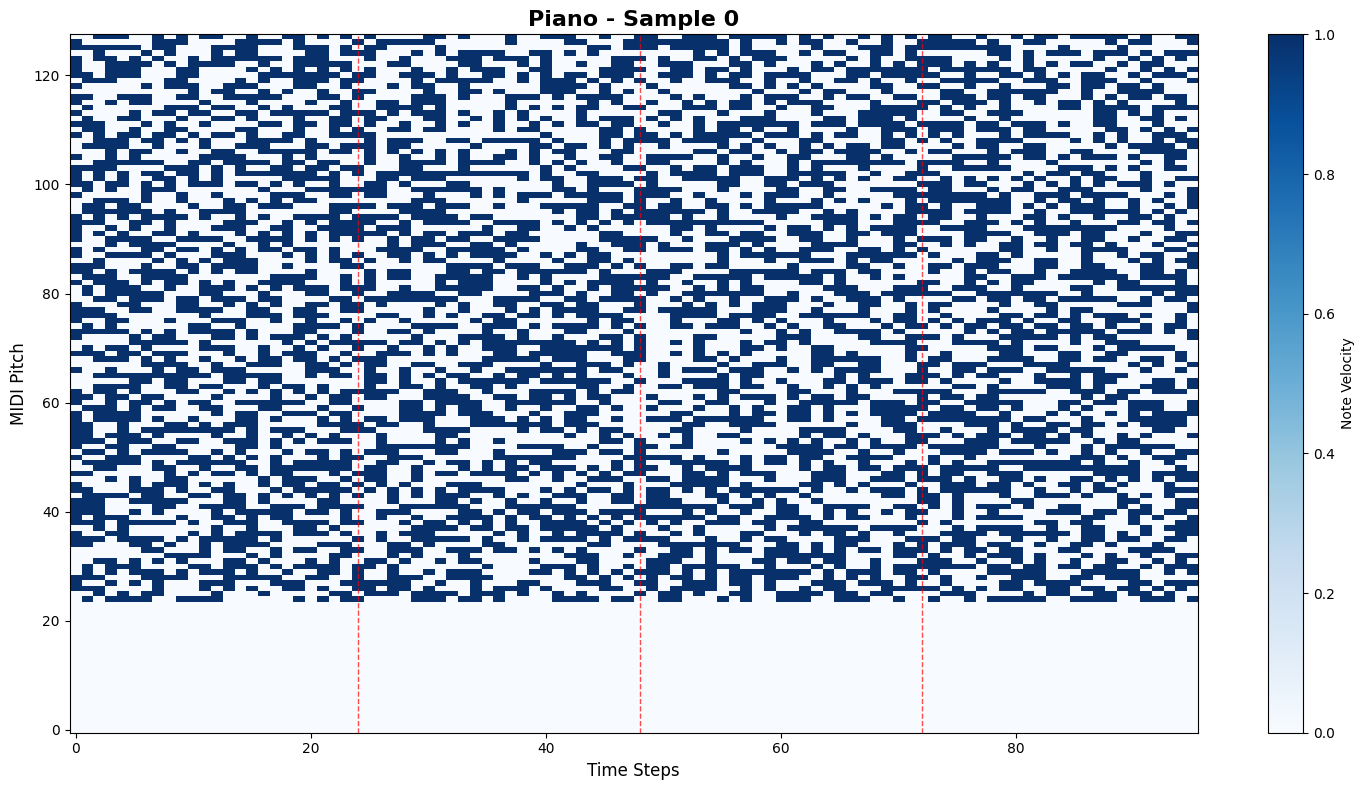

In [ ]:
print(" Creating visualizations...")

# Plot individual track (Piano by default)
print("\n Piano Roll Visualization (Piano Track):")
generator.plot_pianoroll(processed_music, sample_idx=0, track_idx=1)

 All Tracks Comparison:


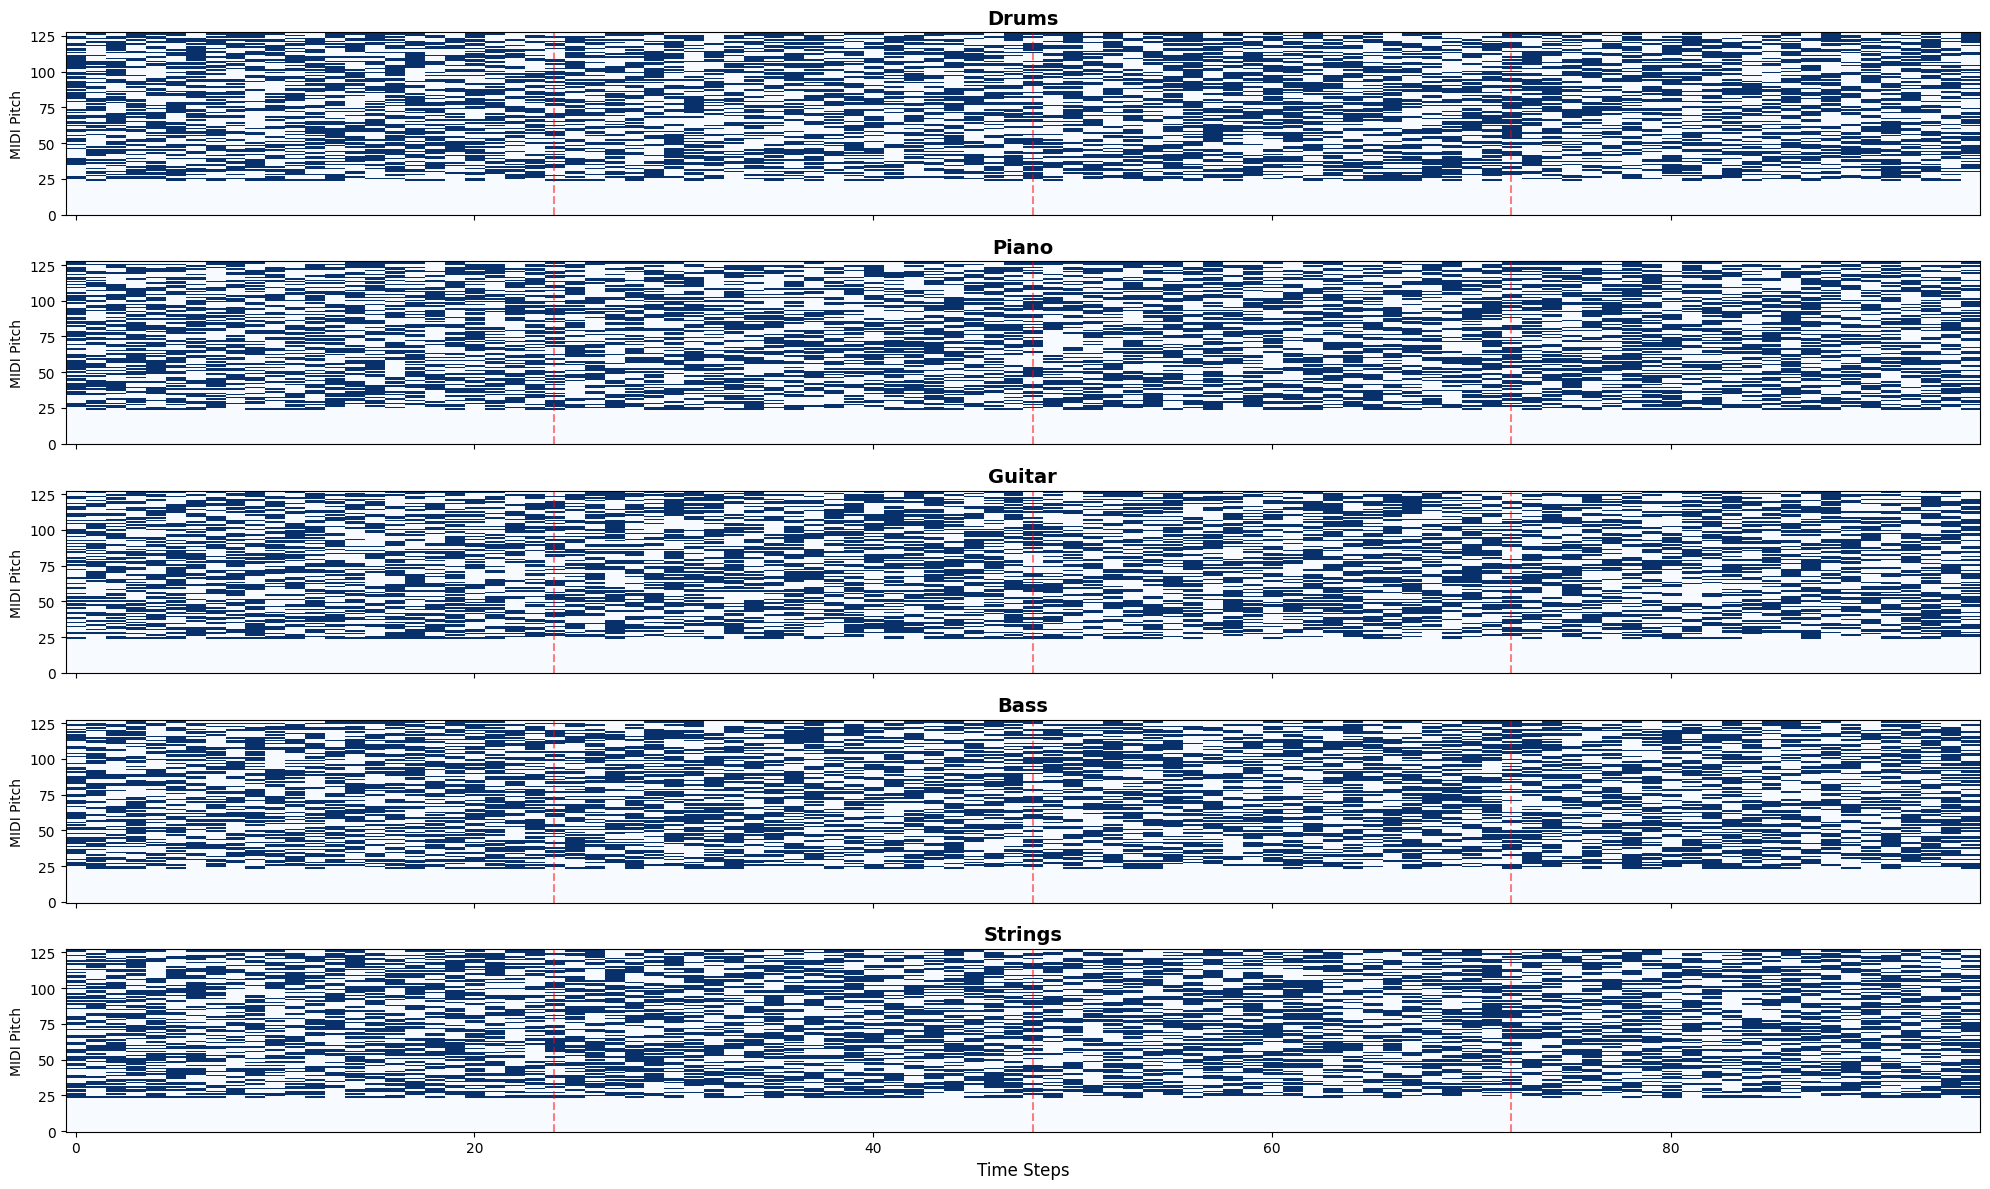

In [ ]:
print(" All Tracks Comparison:")
generator.plot_track_comparison(processed_music, sample_idx=0)

In [ ]:
print(" Saving generated music...")

# Save each sample
for i in range(N_SAMPLES):
    sample_music = processed_music[i:i+1]
    
    # Save as numpy
    numpy_path = os.path.join(OUTPUT_DIR, f'generated_music_sample_{i}.npy')
    generator.save_as_numpy(sample_music, numpy_path)
    
    # Save as MIDI
    midi_path = os.path.join(OUTPUT_DIR, f'generated_music_sample_{i}.mid')
    generator.save_as_midi(sample_music, midi_path)

print(f"\n All files saved to: {OUTPUT_DIR}")


 Saving generated music...
Music saved as numpy array: ./generated_music\generated_music_sample_0.npy
MIDI file saved as: ./generated_music\generated_music_sample_0.mid
Music saved as numpy array: ./generated_music\generated_music_sample_1.npy
MIDI file saved as: ./generated_music\generated_music_sample_1.mid
Music saved as numpy array: ./generated_music\generated_music_sample_2.npy
MIDI file saved as: ./generated_music\generated_music_sample_2.mid
Music saved as numpy array: ./generated_music\generated_music_sample_3.npy
MIDI file saved as: ./generated_music\generated_music_sample_3.mid

 All files saved to: ./generated_music


 Interactive Generation Example:
Generating 2 samples with temperature=1.2, threshold=0.4
Generating 2 music samples...
Error generating music: 'NoneType' object has no attribute 'get_tensor_by_name'
Using random music as fallback...


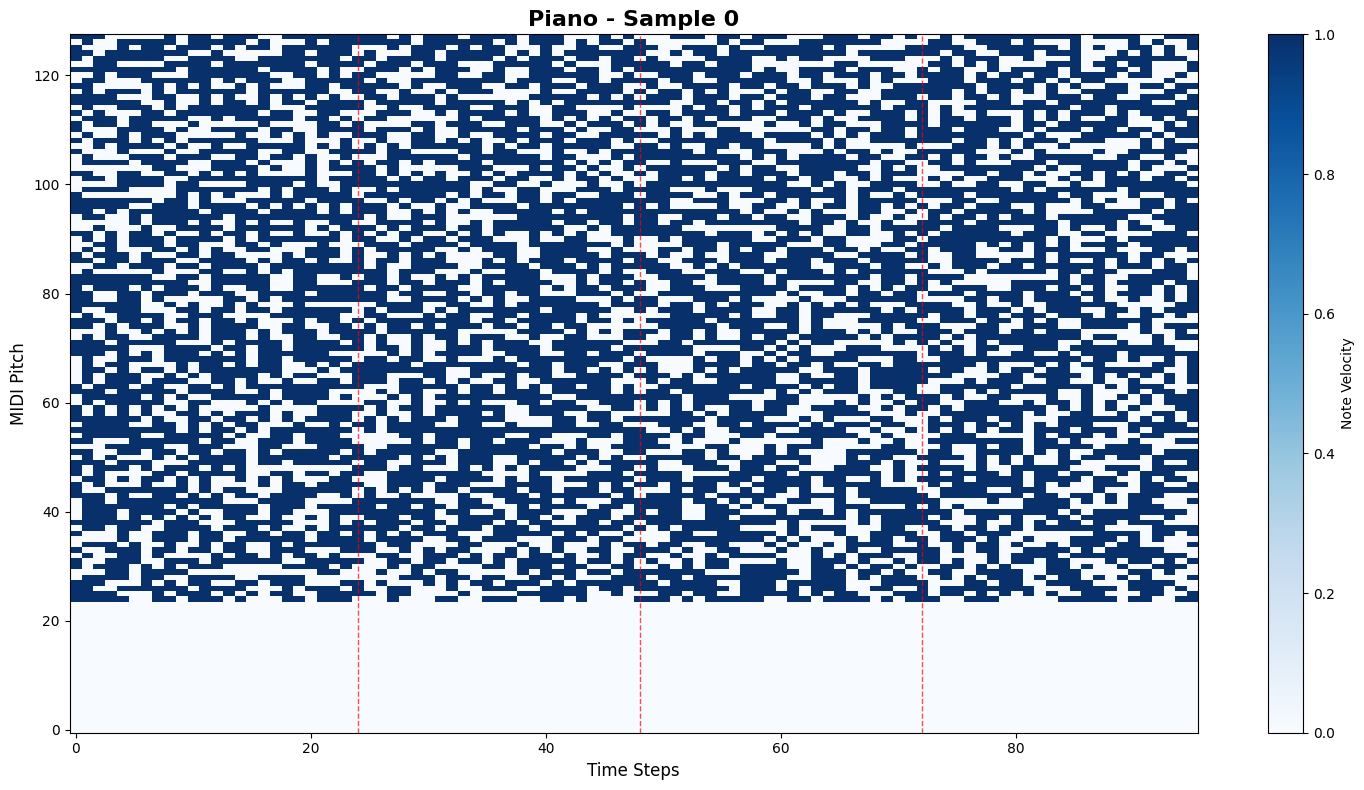


 Piano Statistics:
   Density: 49.1%
   Active Notes: 6,035
   Pitch Range: 24 - 127


In [ ]:
def generate_and_visualize(n_samples=2, temperature=1.0, threshold=0.5, track_to_plot=1):
    """Interactive function to generate and visualize music with custom parameters."""
    print(f"Generating {n_samples} samples with temperature={temperature}, threshold={threshold}")
    
    # Generate music
    music = generator.generate_music(n_samples=n_samples, temperature=temperature)
    processed = generator.postprocess_music(music, threshold=threshold)
    
    # Visualize
    generator.plot_pianoroll(processed, sample_idx=0, track_idx=track_to_plot)
    
    # Show stats
    stats = generator.analyze_music_statistics(processed)
    track_name = generator.track_names[track_to_plot]
    track_stats = stats[track_name]
    
    print(f"\n {track_name} Statistics:")
    print(f"   Density: {track_stats['density']:.1f}%")
    print(f"   Active Notes: {track_stats['active_notes']:,}")
    print(f"   Pitch Range: {track_stats['pitch_range'][0]} - {track_stats['pitch_range'][1]}")
    
    return processed

# Example usage - modify these parameters to experiment
print(" Interactive Generation Example:")
interactive_music = generate_and_visualize(
    n_samples=2, 
    temperature=1.2,  # Try different values: 0.5, 1.0, 1.5, 2.0
    threshold=0.4,    # Try different values: 0.3, 0.5, 0.7
    track_to_plot=1   # 0=Drums, 1=Piano, 2=Guitar, 3=Bass, 4=Strings
)

 Batch Generation with Different Parameters:

Generating with temperature 0.5...
Generating 1 music samples...
Error generating music: 'NoneType' object has no attribute 'get_tensor_by_name'
Using random music as fallback...

Generating with temperature 1.0...
Generating 1 music samples...
Error generating music: 'NoneType' object has no attribute 'get_tensor_by_name'
Using random music as fallback...

Generating with temperature 1.5...
Generating 1 music samples...
Error generating music: 'NoneType' object has no attribute 'get_tensor_by_name'
Using random music as fallback...

Generating with temperature 2.0...
Generating 1 music samples...
Error generating music: 'NoneType' object has no attribute 'get_tensor_by_name'
Using random music as fallback...


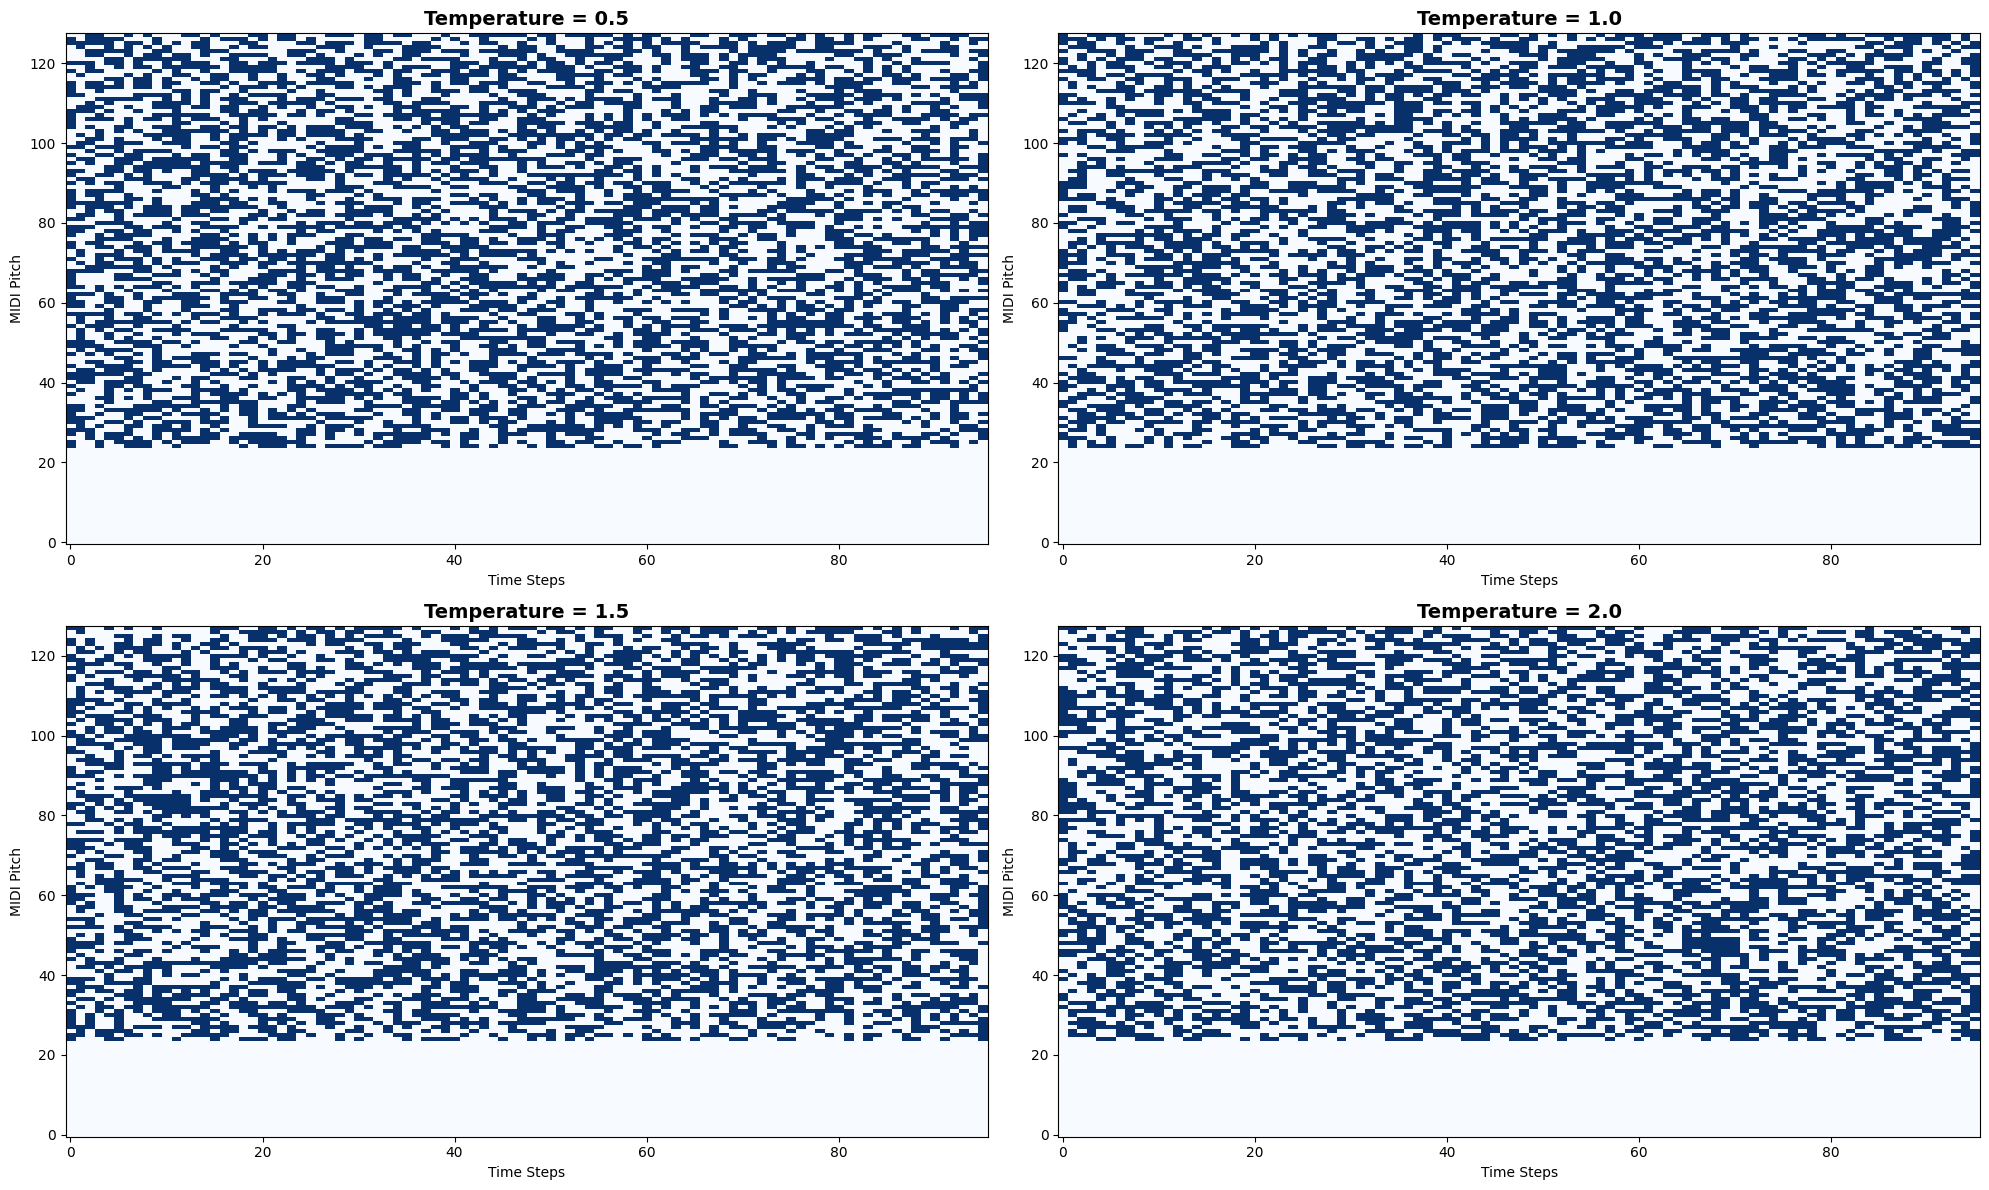

 Notebook execution complete!

 Summary:
   - Generated 4 music samples
   - Saved files to: ./generated_music
   - Model loaded: Non successfully (using fallback)
   - Visualizations created: Yes

 You can now:
   - Modify parameters in Cell 11 for interactive generation
   - Experiment with different temperatures and thresholds
   - Visualize different tracks and samples
   - Load and play the generated MIDI files


In [ ]:
print(" Batch Generation with Different Parameters:")

# Generate multiple versions with different temperatures
temperatures = [0.5, 1.0, 1.5, 2.0]
batch_results = {}

for temp in temperatures:
    print(f"\nGenerating with temperature {temp}...")
    music = generator.generate_music(n_samples=1, temperature=temp)
    processed = generator.postprocess_music(music, threshold=0.5)
    batch_results[temp] = processed

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = axes.flatten()

for i, temp in enumerate(temperatures):
    pianoroll = generator.music_to_pianoroll(batch_results[temp][0], track_idx=1)
    
    im = axes[i].imshow(pianoroll.T, aspect='auto', origin='lower', 
                       cmap='Blues', interpolation='nearest')
    axes[i].set_title(f'Temperature = {temp}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Time Steps')
    axes[i].set_ylabel('MIDI Pitch')

plt.tight_layout()
plt.show()

print(" Notebook execution complete!")
print("\n Summary:")
print(f"   - Generated {N_SAMPLES} music samples")
print(f"   - Saved files to: {OUTPUT_DIR}")
print(f"   - Model loaded: {'Successfully' if model_loaded else 'Non successfully (using fallback)'}")
print(f"   - Visualizations created: Yes")
print("\n You can now:")
print("   - Modify parameters in Cell 11 for interactive generation")
print("   - Experiment with different temperatures and thresholds")
print("   - Visualize different tracks and samples")
print("   - Load and play the generated MIDI files")